# **Линейная регрессия (часть 2)**

**Коптев Данил**

**Подключим библиотеки**

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
import math
import time 

from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Задание 3

**Часть 1**

1) Импортируем данные в DataFrame и выведим несколько первых записей

In [87]:
dataAll = pd.read_csv('HeightsWeights.csv')
dataAll.head()

,Index,Height,Weight
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971


2) Выполним  первичный  анализ  данных: построим  гистограммы  распределения признаков и проанализируем  характер  их  распределения, наличие/отсутствие выбросов.

array([[<Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Weight'}>]], dtype=object)

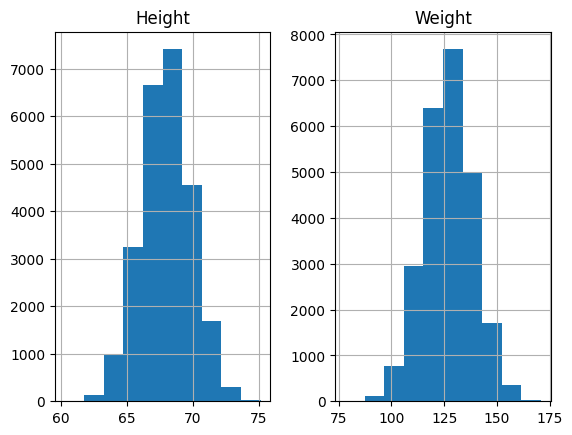

In [88]:
dataAll[['Height', 'Weight']].hist()

**Анализ:** 

Height - имеет распределение близко к нормальному, вероятность наличие выбросов минимальное

Weight - имеет распределение близко к нормальному, вероятность наличие выбросов минимальное

3) Добавим в DataFrame новый признак – индекс массы тела (BMI)

In [89]:
def get_bmi(height, weight) :
  return convert_weight(weight) /(convert_height(height)**2)

def convert_height(height) :
  return height * 0.0254

def convert_weight(weight) :
  return weight * 0.453592

dataAll["BMI"] = get_bmi(dataAll['Height'], dataAll['Weight'])

print(dataAll["BMI"])

0        18.357609
1        18.762615
2        22.338940
3        21.504569
4        22.077625
           ...    
24995    17.179016
24996    20.281906
24997    19.864010
24998    20.392499
24999    18.506055
Name: BMI, Length: 25000, dtype: float64


4) Визуализируем  попарные  зависимости  признаков.  Проанализируем  полученные графики: выясним, есть ли пары признаков, для которых можно предполагать линейную зависимость.

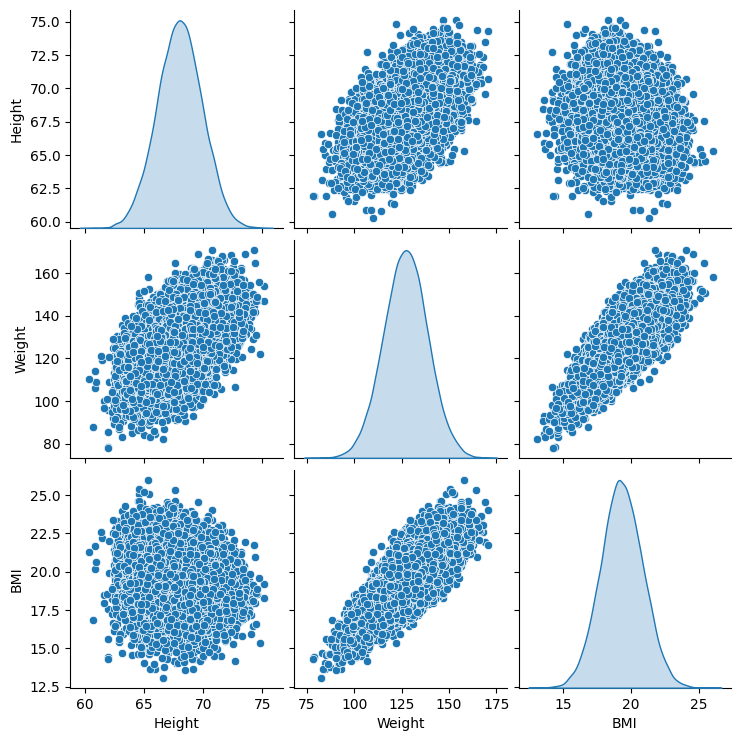

In [90]:
sns.pairplot(dataAll[["Height", "Weight", "BMI"]], diag_kind = "kde")

**Анализ:** на основание построенных попарных графиков мы можем предлопожить о линейной зависимости признаков $Height$ и $Weight$

5) Напишем функцию, которая по двум параметрам $𝑤_0$ и $𝑤_1$ вычисляет квадратичную ошибку  приближения  зависимости  роста 𝑦 от  веса 𝑥 линейной  функцией $𝑦$=$𝑤_0$+$𝑤_1$∙$𝑥$

In [91]:
def get_mse(w):
  return (1/len(dataAll['Height']))*(((dataAll['Height'] * w[0] + w[1] * dataAll['Weight']) ** 2).sum())

6) Реализуем  метод  градиентного  спуска  для  минимизации  ошибки,  обеспечив сохранение на каждой итерации текущего значения ошибки

Перед реализации метода грандиентного спуска нужно учесть то, что у нас слишком разный признак и целевая переменное. Исходя из этого реализуем с мастабироварие признака $Weight$ 

In [92]:
robustScaler = StandardScaler()
weight = np.array(dataAll["Weight"]).reshape(-1, 1)
robustScaler.fit(weight)
dataAll["StandardizedrWeight"] = robustScaler.transform(weight)
dataAll.head()

,Index,Height,Weight,BMI,StandardizedrWeight
0,1,65.78331,112.9925,18.357609,-1.208072
1,2,71.51521,136.4873,18.762615,0.806805
2,3,69.39874,153.0269,22.338940,2.225214
3,4,68.21660,142.3354,21.504569,1.308328
4,5,67.78781,144.2971,22.077625,1.476561


In [93]:
def GD(step):
  eps = 10e-5
  w = np.array([0,0])
   
  t = 0 
  mse_array = [] 

  while True:

    Q = np.array([(2.0 / len(dataAll['Height'])) * np.sum(w[1] * dataAll['StandardizedrWeight'] + w[0] - dataAll['Height']), 
                   (2.0 / len(dataAll['Height'])) * np.sum((w[1] * dataAll['StandardizedrWeight'] + w[0] - dataAll['Height']) * dataAll['StandardizedrWeight'])])
    
    if (np.sqrt(np.sum(np.square(Q))) < eps):
      break

    w = w - step * Q

    t += 1
    mse_array.append(get_mse(w))

  return w, t, mse_array

7) Применим  градиентный  спуск  к  имеющемуся  набору  данных

In [94]:
w, t, mse_array = GD(0.0001)
print(f"Количество итераций: {t}")
print(f"Уравнение: y = {w[0]} + {w[1]} * x")

Количество итераций: 70608
Уравнение: y = 67.99306360271802 + 0.956255544003083 * x


8) Выведим на одном графике исходный набор данных в координатах вес –рост и прямую регрессии с оптимальными значениями коэффициентов.ч

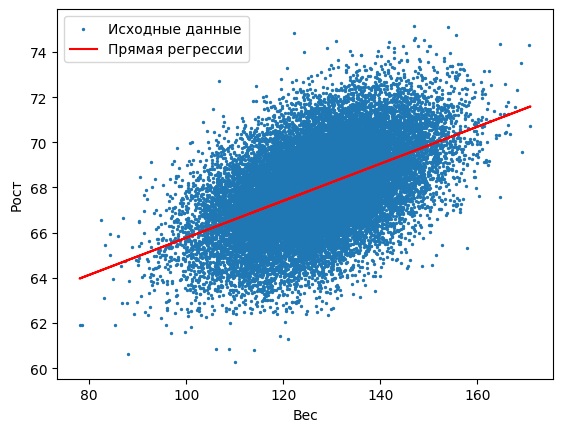

In [95]:
plt.scatter(dataAll["Weight"], dataAll["Height"], s = 2, label = "Исходные данные")
plt.plot(dataAll["Weight"], dataAll["StandardizedrWeight"] * w[1] + w[0], color = 'red', label = "Прямая регрессии")
plt.xlabel("Вес")
plt.ylabel("Рост")
plt.legend()

9) Выведим график, показывающий изменение значения ошибки алгоритма в зависимости от номера итерации

Text(0, 0.5, 'MSE')

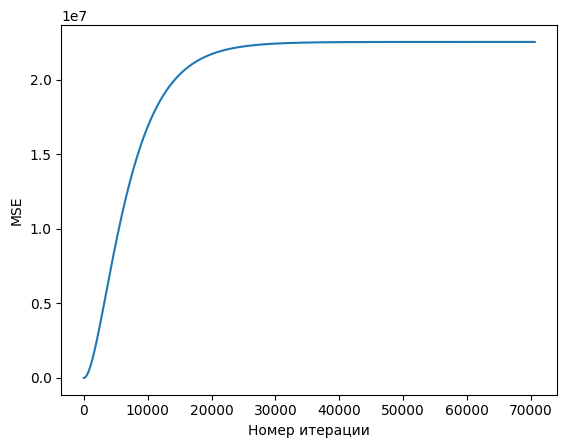

In [96]:
plt.plot(np.linspace(0, t, t), mse_array)
plt.xlabel("Номер итерации")
plt.ylabel("MSE")

**Часть 2**

1) Реализуем метод стохастического градиентного спуска для минимизации ошибки, обеспечив сохранение на каждой итерации текущего значения ошибки

In [97]:
def get_smse(w, random):
  return (1/len(dataAll['Height']))*(((dataAll['Height'].iloc[random] * w[0] + w[1] * dataAll['Weight'].iloc[random]) ** 2).sum())

def SGD(step):
  eps = 10e-5
  w = np.array([0,0])

  t = 0 
  mse_array = [] 
  while True: 
    rnd = np.random.randint(0, 25000)

    Q = np.array([2 * (w[1] * dataAll["StandardizedrWeight"].iloc[rnd] + w[0] - dataAll["Height"].iloc[rnd]), 
                   2 * ((w[1] * dataAll["StandardizedrWeight"].iloc[rnd] + w[0] - dataAll["Height"].iloc[rnd]) * dataAll["StandardizedrWeight"].iloc[rnd])])

    if (np.sqrt(np.sum(np.square(Q))) < eps):
      break

    w = w - step * Q

    t += 1
    mse_array.append(get_smse(np.array([w[0],w[1]]), rnd))

  return w, t, mse_array

2) Применим стохастический градиентный спуск к имеющемуся набору данных; выведим уравнение полученной  линейной  зависимости  с  оптимальными  значениями коэффициентов и число итераций, выполненных алгоритмом до достижения условия останова

In [98]:
w, t, smse_array = SGD(0.0001)
print(f"Количество итераций: {t}")
print(f"Уравнение: y = {w[0]} + {w[1]} * x")

Количество итераций: 121954
Уравнение: y = 68.00605437055712 + 0.9713717793262264 * x


3) Выведим на одном графике исходный набор данных в координатах вес – рост и прямую регрессии  с  оптимальными  значениями  коэффициентов,  полученных  с  помощью стохастического градиентного спуска.

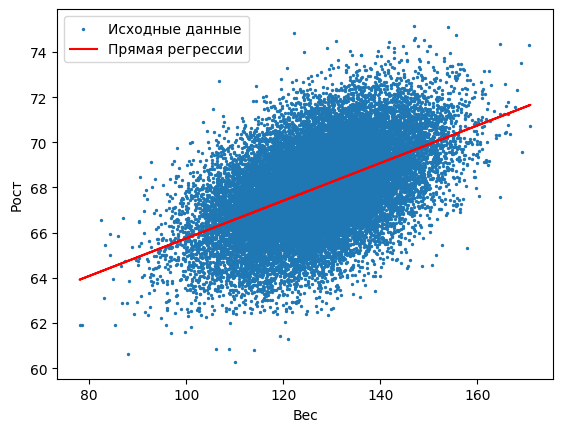

In [99]:
plt.scatter(dataAll["Weight"], dataAll["Height"], s = 2, label = "Исходные данные")
plt.plot(dataAll["Weight"], dataAll["StandardizedrWeight"] * w[1] + w[0], color = 'red', label = "Прямая регрессии")
plt.xlabel("Вес")
plt.ylabel("Рост")
plt.legend()

4) Выведим график, показывающий изменение значения ошибки алгоритма в зависимости от номера итерации

Text(0, 0.5, 'SMSE')

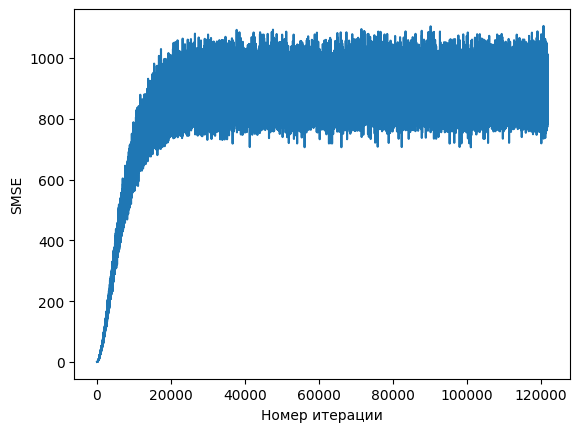

In [100]:
plt.plot(smse_array)
plt.xlabel("Номер итерации")
plt.ylabel("SMSE")

5) Сравним результаты работы алгоритмов Full  GD и SGD по достигнутому значению функции ошибки, числу итераций и затраченному времени

In [101]:
%%time
w_gd, t_gd, mse_array_gd = GD(0.0001)
print(t_gd)

70608
CPU times: user 1min 31s, sys: 361 ms, total: 1min 32s
Wall time: 1min 32s


In [102]:
%%time
w_sgd, t_sgd, mse_array_sgd = SGD(0.0001)
print(t_sgd)

67682
CPU times: user 5.56 s, sys: 10.8 ms, total: 5.57 s
Wall time: 5.59 s


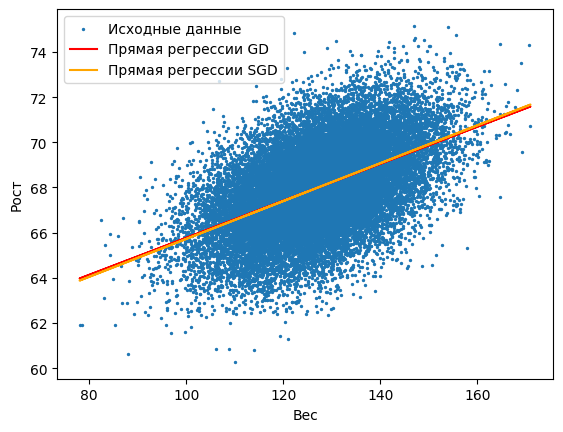

In [103]:
plt.scatter(dataAll["Weight"], dataAll["Height"], s = 2, label = "Исходные данные")
plt.plot(dataAll["Weight"], dataAll["StandardizedrWeight"] * w_gd[1] + w_gd[0], color = 'red', label = "Прямая регрессии GD")
plt.plot(dataAll["Weight"], dataAll["StandardizedrWeight"] * w_sgd[1] + w_sgd[0], color = 'orange', label = "Прямая регрессии SGD")
plt.xlabel("Вес")
plt.ylabel("Рост")
plt.legend()

6) Проанализируем полученные результаты

**Анализ**

Как мы можем заметить каждый шаг SGD(5.59 s) выполняется существенно быстрее шага GD(1min 32s)

SGD завершает свой метод за 67682 итераций, но они могут различаться, а вот GD за свои стабильные 70608

SGD более быстрый, но менее стабильный метод, так как значения в каждом запуске могут отличаться 

**Вывод** 

При одинаков шаге SGD работает быстрее, но менее точен в отличие от Full GD

Full GD заставляет постоянно хранить всю обучающую выборку в
памяти и работает дольше, но за счет этого более стабильный и точный

**Часть 3**

1) выполним разовое разбиение данных исходного набора на обучающую и тестовую выборки в соотношении 95/5.

In [104]:
x_train, x_test, y_train, y_test = train_test_split(dataAll["StandardizedrWeight"], dataAll["Height"], test_size=0.05, train_size = 0.95, random_state = 42)

2) Выделим значения прогнозируемого признака (рост)  в  отдельный объект (и  для обучающей, и для тестовой  выборки) Удалить  соответствующий  столбец  из обучающего и тестового наборов.

In [105]:
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)
y_train = y_train.ravel()
y_test = np.array(y_test).reshape(-1, 1)

3) На обучающей выборке обучим две модели линейной регрессии: LinearRegressionи SGDRegressor.

Выведим фактическое число итераций, выполненных алгоритмами до достижения условия останова

In [106]:
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)

sgd_regressor = SGDRegressor(max_iter=10000, tol=1e-4, random_state=42)
sgd_regressor.fit(x_train, y_train)
print("Число итераций SGDRegressor:", sgd_regressor.n_iter_)

Число итераций SGDRegressor: 8


4) Получим предсказания обученных моделей для объектов тестовой выборки. 

In [107]:
linear_predict = linear_regression.predict(x_test)
sgd_predict= sgd_regressor.predict(x_test)

Выведим массивы ответов на тестовой выборке и массив предсказанных моделью значений

In [108]:
print("Тестовая выборка:", y_test)
print("Значения полученные с помощью LinearRegression:", linear_predict)
print("Значения полученные с помощью SGDRegressor:", sgd_predict)

Тестовая выборка: [[68.42447]
 [67.89663]
 [67.65922]
 ...
 [67.8791 ]
 [70.05957]
 [64.37686]]
Значения полученные с помощью LinearRegression: [68.58221594 66.7542449  68.72158103 ... 67.66374626 68.94685353
 66.20765298]
Значения полученные с помощью SGDRegressor: [68.64687687 66.76628529 68.79025377 ... 67.70196784 69.02201103
 66.20395901]


Представим результаты в графической форме

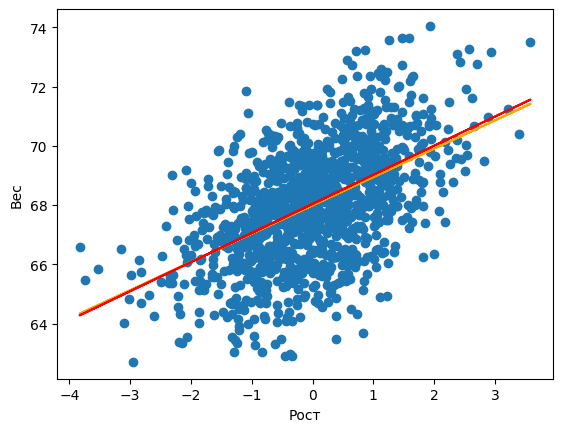

In [109]:
plt.scatter(x_test, y_test, label='Тестовые значения')
plt.plot(x_test, linear_predict, color='orange', label='Значения LinearRegression')
plt.plot(x_test, sgd_predict, color='red', label='Значения SGDRegressor')
plt.xlabel('Рост')
plt.ylabel('Вес')
plt.show()

5) Запишем полученные уравнения регрессии

In [110]:
print(f"Уравнение регрессии LinearRegression: y = {linear_regression.intercept_} + {linear_regression.coef_[0]}*x1")

Уравнение регрессии LinearRegression: y = 67.99202092795063 + 0.9550361689355833*x1


In [111]:
print(f"Уравнение регрессии SGDRegressor: y = {sgd_regressor.intercept_[0]} + {sgd_regressor.coef_[0]}*x1")

Уравнение регрессии SGDRegressor: y = 68.03969232315688 + 0.9825281363909326*x1


6) Проанализируем все полученные результаты, сделаем выводы

**Анализ**

Уравнение регрессии получившееся с помощью LinearRegression и SGDRegressor отличается, но не значительно по сравнению с уравнением регрессии Full GD и SGD 

Графики значений LinearRegression и значений SGDRegressor отличаются, но не существенно

**Вывод**

Исходя из выше сказанного можно утверждать, что представленное решение работает верно

# Задание 4

1) Оценим качество двух моделей регрессии, полученных при выполнении части 3 задания 3. Для оценки используем метрики MSE, MAE и 𝑅2. В целях более корректного сопоставления оценок MSE и MAE найти значение квадратного корня из MSE.

In [112]:
mse_lin = mean_squared_error(y_test, linear_predict)
mae_lin = mean_absolute_error(y_test, linear_predict)
rmse_lin = np.sqrt(mse_lin)
r2_lin = r2_score(y_test, linear_predict)

mse_sgd = mean_squared_error(y_test, sgd_predict)
mae_sgd = mean_absolute_error(y_test, sgd_predict)
rmse_sgd = np.sqrt(mse_sgd)
r2_sgd = r2_score(y_test, sgd_predict)

print("LinearRegression:")
print(f"MSE: {mse_lin}")
print(f"MAE: {mae_lin}")
print(f"RMSE: {rmse_lin}")
print(f"R2: {r2_lin}")
print("\nSGDRegressor:")
print(f"MSE: {mse_sgd}")
print(f"MAE: {mae_sgd}")
print(f"RMSE: {rmse_sgd}")
print(f"R2: {r2_sgd}")

LinearRegression:
MSE: 2.75010191758226
MAE: 1.3226754629355404
RMSE: 1.6583431242002542
R2: 0.27251266605391833

SGDRegressor:
MSE: 2.7497394750137376
MAE: 1.3214052960157712
RMSE: 1.6582338420782932
R2: 0.2726085433652998


2) Дадим интерпретацию полученным результатам.

**Интепретация:**

Качество моделей примерно на одном уровне

У моделей одинаковое колличество ошибок

$RMSE$ можно считать чувствительной к аномальным значениям, но учитвая, что его значение невелико можно сказать, что аномалии незначительны

Модель является разумной, так как  $0$ $≤$ $R^2$ $≤$ $1$;

Прогнозы сопоставимы по качеству с константным предсказанием, так как $R^2$ ближе к $0$

